In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
import numpy as np
import re 

from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform
from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array
from torch.utils.data import DataLoader
from project.model import VisionTransformer
from torch.optim import Adam
from project.model.fitter import Fitter
from matplotlib import pyplot as plt
from tqdm import tqdm

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.16 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
dir_path = 'experiments/'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
file_num = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])

In [3]:
# log_dir = 'vit_test_logs'
# filename_log = f'{log_dir}/training_log_Vit{file_num + 1}.log'

# # Ensure the log directory exists
# if not os.path.exists(log_dir):
#     os.makedirs(log_dir)

# # Configure logging to log to the specified file
# logging.basicConfig(filename=filename_log, level=logging.INFO)

In [4]:
d_model = 16*16
n_classes = 2
img_size = (16,16)
patch_size = (2,2)
n_channels = 1
n_heads = 2
n_layers = 3
batch_size = 1
epochs = 3
alpha = 0.000125

In [5]:
Moddel_info= f'Creating model with d_model={d_model}, n_classes={n_classes}, img_size={img_size}, patch_size={patch_size}, n_channels={n_channels}, n_heads={n_heads}, n_layers={n_layers}, batch_size={batch_size}, epochs={epochs}, alpha={alpha}'
logging.info(Moddel_info)

INFO:root:Creating model with d_model=256, n_classes=2, img_size=(16, 16), patch_size=(2, 2), n_channels=1, n_heads=2, n_layers=3, batch_size=1, epochs=3, alpha=0.000125


In [6]:
ds = Dataset()

In [7]:
# masks = ds.load_cmb_masks()
# cases = ds.load_raw_mri()
# cases = ds.load_skullstripped_mri(cohort_num=1)

masks = ds.load_cmb_masks(cohort_num=1)
cases = ds.load_raw_mri(cohort_num=1)

# cases = ds.load_skullstripped_mri()
# masks = ds.load_cmb_masks()

In [8]:
transform = NiftiToTensorTransform(target_shape=(512,512))

In [9]:
dataset = VALDODataset(
    cases=cases, 
    masks=masks, 
    transform=transform,
    normalization=z_score_normalization
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [10]:
print(type(dataset))
print(len(dataset))

<class 'project.dataset.valdo.VALDODataset'>
11


In [11]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.cases,
    'Segmented Masks': dataset.masks,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

In [12]:
train_dataset, val_dataset = split_train_val_datasets(
    df=df_dataset, 
    transform=transform
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [13]:
train_loader = DataLoader(
    train_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
transformer = VisionTransformer(
    D_model=d_model,
    N_classes=n_classes,
    Img_size=img_size,
    Patch_size=patch_size,
    N_channels=n_channels,
    N_heads=n_heads,
    N_layers=n_layers,
    device=device
)

In [16]:
transformer = transformer.to(device)

In [17]:
optimizer = Adam
criterion = nn.CrossEntropyLoss()

In [18]:
import matplotlib.pyplot as plt
def print_image(img, title):
    plt.imshow(img, cmap='hot')
    plt.title(title)
    plt.show()

In [19]:
class ViTFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        for case in train_loader:
            if torch.unique(case[1]).numel() > 1:
                num_slices= len(case[1]) # Number of slices
                case_number = re.search(r'sub-(\d+)', case[2][0]).group(1) # Extract the case number
                # print(f'Case: {case_number}')
                logging.info(f'Training with Case: {case_number}')
                if num_slices != len(case[0]):
                    # print('Not equal Number of slices:', num_slices, data[0]) #Checks if the number of slices of the MRI and the mask are the same
                    logging.error(f'Not equal Number of slices: {num_slices} MRI: {len(case[0])} Mask: {len(data[1])}')
                    break
                for j in range(num_slices):
                    bounding_boxes = dataset.extract_bounding_boxes(case[1][j][0].numpy()) #Extracts all the bounding boxes of the slice 
                    cropped_images = []
                    cropped_labels = []
                    coordinates = []
                    if len(bounding_boxes) <= 0: # If there are no bounding boxes then it will skip the slice
                        # print('No bounding boxes found on slice ', j)
                        logging.warning(f'No bounding boxes found on slice {j}')
                        continue
                    for bbox in bounding_boxes: # For each bounding box it will crop the image and the label based on the given coordinates
                        # print(f"Slice {j} | ", bbox) 
                        logging.info(f'Slice {j} | {bbox}')
                        # print(data[0][j][0].shape)
                        logging.info(f'Image shape: {case[0][j][0].shape}')
                        cropped_images.append(
                            dataset.get_cropped_locations(
                                img = case[0], 
                                x_min=bbox[0],
                                y_min=bbox[1],
                                x_max=bbox[2],
                                y_max=bbox[3]
                            ))
                        cropped_labels.append(
                            dataset.get_cropped_locations(
                                img = case[1], 
                                x_min=bbox[0],
                                y_min=bbox[1],
                                x_max=bbox[2],
                                y_max=bbox[3]
                            ))
                        coordinates.append(bbox)
                    if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]): ## Checks if the number of cropped images and labels are the same
                        print('Not equal cropped images and labels')
                        logging.error(f'Not equal cropped images and labels')    
                        break

                        # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                    # print('Cropped Images length:', len(cropped_images))
                    # print('Cropped Labels length:', len(cropped_labels))
                    # print('Cropped Images number of slices:', len(cropped_images[0][0][0])) # This is the MRI image of the CMB with the coordinate
                    # print('Cropped Labels number of slices:', len(cropped_labels[0][0])) # This is the mask of the CMB with the coordinate
                    logging.info(f'Cropped Images length: {len(cropped_images)}')
                    logging.info(f'Cropped Labels length: {len(cropped_labels)}')
                    logging.info(f'Cropped Images number of slices: {len(cropped_images[0][0][0])}')
                    logging.info(f'Cropped Labels number of slices: {len(cropped_labels[0][0])}')
                    for k, cmb in enumerate(cropped_labels[0]): # Access the CMB labels array the n checks if there are CMBs on the slice of the case 
                         for l, cmb_slice in enumerate(cmb):
                            # print(cmb_slice.shape)
                            if torch.unique(cmb_slice).numel() > 1:
                                # print('Multiple classes found on silce: ', l)
                                # print(cmb_slice.shape)
                                # print(cropped_images[0][0][0][l].shape)
                                logging.info(f'Multiple classes found on slice: {l}')
                                logging.info(f'Mask shape: {cmb_slice.shape}')
                                logging.info(f'Image shape: {cropped_images[0][0][0][l].shape}')
                                # Enable ths method to visually see what is feeded on the model 
                                # print_image(cropped_images[0][0][0][l], f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                # print_image(cmb_slice, f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                # print(f'Learning on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                logging.info(f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                logging.info(f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                logging.info(f'Learning on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                self.optimizer.zero_grad()
                                inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                                labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                                # print("Feeded inputs shape: ",inputs.shape)
                                # print("Feeded mask shape: ",labels.shape)
                                logging.info(f'Feeded inputs shape: {inputs.shape}')
                                logging.info(f'Feeded mask shape: {labels.shape}')
                                outputs = transformer(inputs.float(), labels.float())
                                loss = criterion(outputs, labels.long())  
                                # print("Output shape: ",outputs.shape)
                                logging.info(f'Output shape: {outputs.shape}')
                                loss.backward()
                                self.optimizer.step()
                                loss_history.append(loss.item())
                                logging.info(f'Loss: {loss.item()}')
                print("Training Loss: ", loss_history[-1]) # Prints the last loss of the epoch
            else:
                # print('Skipping case with no CMBs')
                logging.warning('Skipping case with no CMBs')
                continue
        return loss_history
    
    def validation(self, val_loader):
        def predict(model, image, mask):
            model.eval()
            with torch.no_grad():
                image = image.to(device)
                output = self.model(images = image, mask = mask)
                output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
                prediction = torch.argmax(output, dim=1)
            return prediction.cpu().numpy()
        loss_history = []
        with torch.no_grad():
            for val_batch in val_loader:
                num_slices = len(val_batch[1])#Number of slces
                one_case = []#This is where we store every slice of the case 
                case_number = re.search(r'sub-(\d+)', val_batch[2][0]).group(1) # Extract the case number
                one_case.append(case_number)

                # print(f'Validation with Case: {case_number}')
                logging.info(f'Validation with Case: {case_number}')
                if num_slices != len(val_batch[0]):
                    # print('Not equal Number of slices:', num_slices, val_batch[0])#Checks if the number of slices of the MRI and the mask are the same
                    logging.error(f'Not equal Number of slices: {num_slices} MRI: {len(val_batch[0])} Mask: {len(val_batch[1])}')
                    break
                for j in range(num_slices):
                    bounding_boxes = dataset.extract_bounding_boxes(val_batch[1][j][0].numpy())#Extracts all the bounding boxes of the slice
                    cropped_images = []
                    cropped_labels = []
                    coordinates = []
                    if len(bounding_boxes) > 0: # If there are no bounding boxes then it will skip the slice
                        # print('No bounding boxes found on slice ', j)
                        logging.warning(f'No bounding boxes found on slice {j}')
                        for bbox in bounding_boxes: #For each bounding box it will crop the image and the label based on the given 
                            # print(f"Slice {j} | ", bbox)
                            logging.info(f'Slice {j} | {bbox}')
                            print(val_batch[0][j][0].shape)
                            cropped_images.append(
                                dataset.get_cropped_locations(
                                    img = val_batch[0], 
                                    x_min=bbox[0],
                                    y_min=bbox[1],
                                    x_max=bbox[2],
                                    y_max=bbox[3]
                                ))
                            cropped_labels.append(
                                dataset.get_cropped_locations(
                                    img = val_batch[1], 
                                    x_min=bbox[0],
                                    y_min=bbox[1],
                                    x_max=bbox[2],
                                    y_max=bbox[3]
                                ))
                            coordinates.append(bbox)
                        if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]):## Checks if the number of cropped images and labels are the same
                            # print('Not equal cropped images and labels')
                            logging.error(f'Not equal cropped images and labels')
                            break
                        # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                        for k, cmb in enumerate(cropped_labels[0]):# Access the CMB labels array the n checks if there are CMBs on the slice of the case
                            for l, cmb_slice in enumerate(cmb):
                                if torch.unique(cmb_slice).numel() > 1:
                                    # print(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                    logging.info(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                    inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                                    labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                                    predicted_mask = predict(transformer, image = inputs.float(), mask = labels.float().to(device))
                                    predicted_mask = torch.tensor(predicted_mask).to(device)
                                    loss = criterion(predicted_mask.float(), labels.float())
                                    loss_history.append(loss.item())
            return loss_history 

In [20]:
config = {
    'model' : transformer,
    'device' : device,
    'epochs': epochs,
    'loss' : criterion,
    'optimizer' : optimizer,
    'lr': alpha
}

In [21]:
fitter = ViTFitter(config)

In [22]:
import os

# Create the directory if it doesn't exist
save_dir = 'experiments/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [23]:
hist = fitter.fit(train_loader, val_loader, file_num)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:root:Training with Case: 111
INFO:root:Slice 9 | [263, 338, 267, 343]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 9
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 111 Slice 9 CMB coordinates [263, 338, 267, 343]
INFO:root:Mask Case 111 Slice 9 CMB coordinates [263, 338, 267, 343]
I

Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(8.6339, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 9.546440124511719
INFO:root:Multiple classes found on slice: 19
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 111 Slice 19 CMB coordinates [279, 177, 287, 185]
INFO:root:Mask Case 111 Slice 19 CMB coordinates [279, 177, 287, 185]
INFO:root:Learning on Case 111 Slice 19 CMB coordinates [279, 177, 287, 185]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 4.577482223510742
INFO:root:Slice 19 | [356, 211, 361, 217]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 19 | [279, 176, 288, 186]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:ro

Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(9.5464, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(4.5775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(3.5933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(4.7087, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch

INFO:root:Training with Case: 101
INFO:root:Slice 8 | [164, 327, 172, 336]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 8 | [180, 299, 184, 303]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 8
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 101 Slice 8 CMB coordinates [164, 327, 172, 336]
INFO:root:Mask Case 101 Slice 8 CMB coordinates [164, 327, 172, 336]
INFO:root:Learning on Case 101 Slice 8 CMB coordinates [164, 327, 172, 336]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 3.9180431365966797
INFO:root:Slice 9 | [257, 320, 260, 324]
INFO:root:Image shape: torch.Size([1, 512

Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(3.9180, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.8052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.4769, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.2765, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch

INFO:root:Loss: 3.265977144241333
INFO:root:Slice 17 | [268, 288, 279, 299]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 17 | [271, 226, 275, 230]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 16
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 101 Slice 16 CMB coordinates [268, 288, 279, 299]
INFO:root:Mask Case 101 Slice 16 CMB coordinates [268, 288, 279, 299]
INFO:root:Learning on Case 101 Slice 16 CMB coordinates [268, 288, 279, 299]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 3.5218915939331055
INFO:root:Multiple classes found on slice: 17
INFO:root:Mask shape: torch.Si

Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(3.5219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.9875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.3846, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  2.384629487991333


INFO:root:Training with Case: 103
INFO:root:Slice 5 | [132, 278, 138, 283]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 5
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 103 Slice 5 CMB coordinates [132, 278, 138, 283]
INFO:root:Mask Case 103 Slice 5 CMB coordinates [132, 278, 138, 283]
INFO:root:Learning on Case 103 Slice 5 CMB coordinates [132, 278, 138, 283]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 2.112215042114258
INFO:root:Slice 17 | [236, 244, 245, 253]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 17 | [212, 229, 218, 234]
INFO:root:Image shape: torch.Size([1, 51

Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.1122, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.0734, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.2994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.4648, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch

INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 20 | [185, 183, 192, 193]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 20
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 103 Slice 20 CMB coordinates [252, 199, 257, 204]
INFO:root:Mask Case 103 Slice 20 CMB coordinates [252, 199, 257, 204]
INFO:root:Learning on Case 103 Slice 20 CMB coordinates [252, 199, 257, 204]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.5374877452850342
INFO:root:Slice 21 | [243, 218, 247, 222]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels l

Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.5375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0567, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  1.0566868782043457


INFO:root:Training with Case: 106
INFO:root:Slice 11 | [85, 308, 89, 312]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 11
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 106 Slice 11 CMB coordinates [85, 308, 89, 312]
INFO:root:Mask Case 106 Slice 11 CMB coordinates [85, 308, 89, 312]
INFO:root:Learning on Case 106 Slice 11 CMB coordinates [85, 308, 89, 312]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.9571807384490967
INFO:root:Slice 13 | [99, 318, 103, 322]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropp

Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9572, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9995, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1745, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  1.17446768283844


INFO:root:Training with Case: 108
INFO:root:Slice 15 | [273, 292, 277, 297]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 15 | [277, 228, 280, 232]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 15 | [268, 220, 272, 224]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 3
INFO:root:Cropped Labels length: 3
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 15
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 108 Slice 15 CMB coordinates [273, 292, 277, 297]
INFO:root:Mask Case 108 Slice 15 CMB coordinates [273, 292, 277, 297]
INFO:root:Learning on Case 108 Slice 15 CMB coordinates [273, 292, 277, 297]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.89

Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.2550, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0224, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1117, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch

INFO:root:Multiple classes found on slice: 16
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 108 Slice 16 CMB coordinates [254, 290, 277, 307]
INFO:root:Mask Case 108 Slice 16 CMB coordinates [254, 290, 277, 307]
INFO:root:Learning on Case 108 Slice 16 CMB coordinates [254, 290, 277, 307]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 2.171785831451416
INFO:root:Multiple classes found on slice: 17
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 108 Slice 17 CMB coordinates [254, 290, 277, 307]
INFO:root:Mask Case 108 Slice 17 CMB coordinates [254, 290, 277, 307]
INFO:root:Learning on Case 108 Slice 17 CMB coordinates [254, 290, 277, 307]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 

Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.1718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.7714, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0376, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  1.0376076698303223


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:root:Training with Case: 102
INFO:root:Slice 17 | [246, 316, 255, 325]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 17
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 102 Slice 17 CMB coordinates [246, 316, 255, 325]
INFO:root:Mask Case 102 Slice 17 CMB coordinates [246, 316, 255, 325]
INFO:root:Learning on Case 102 Slice 17 CMB coordinates [246, 316, 255, 325]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.389826774597168
pixdim[0] (qfac) sho

Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.3898, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  1.389826774597168


INFO:root:Validation with Case: 110
INFO:root:Slice 11 | [151, 359, 155, 362]
INFO:root:Slice 11 | [111, 210, 115, 214]
INFO:root:Slice 11 | [165, 159, 170, 164]
INFO:root:Predicting on Case 110 Slice 11 CMB coordinates [151, 359, 155, 362]
INFO:root:Slice 14 | [95, 235, 100, 239]
INFO:root:Predicting on Case 110 Slice 14 CMB coordinates [95, 235, 100, 239]
INFO:root:Slice 18 | [241, 309, 245, 313]
INFO:root:Predicting on Case 110 Slice 18 CMB coordinates [241, 309, 245, 313]
INFO:root:Slice 19 | [85, 230, 91, 236]
INFO:root:Slice 19 | [102, 197, 106, 200]
INFO:root:Predicting on Case 110 Slice 19 CMB coordinates [85, 230, 91, 236]
INFO:root:Predicting on Case 110 Slice 21 CMB coordinates [85, 230, 91, 236]
INFO:root:Slice 20 | [93, 311, 97, 315]
INFO:root:Slice 20 | [363, 229, 366, 233]
INFO:root:Slice 20 | [133, 161, 137, 165]
INFO:root:Predicting on Case 110 Slice 20 CMB coordinates [93, 311, 97, 315]
INFO:root:Slice 21 | [82, 312, 86, 316]
INFO:root:Slice 21 | [91, 255, 97, 260]
IN

torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8212, device='cuda:0')
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.2106, device='cuda:0')
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9066, device='cuda:0')
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.5042, device='cuda:0')
Input shape before classif

INFO:root:Slice 23 | [182, 234, 186, 239]
INFO:root:Slice 23 | [111, 226, 118, 233]
INFO:root:Slice 23 | [91, 214, 96, 220]
INFO:root:Slice 23 | [97, 213, 101, 218]
INFO:root:Slice 23 | [96, 170, 102, 175]
INFO:root:Slice 23 | [103, 162, 110, 169]
INFO:root:Predicting on Case 110 Slice 23 CMB coordinates [182, 234, 186, 239]
INFO:root:Slice 24 | [114, 247, 118, 251]
INFO:root:Slice 24 | [119, 232, 125, 239]
INFO:root:Slice 24 | [108, 224, 118, 233]
INFO:root:Slice 24 | [100, 219, 103, 223]
INFO:root:Slice 24 | [86, 209, 91, 216]
INFO:root:Slice 24 | [99, 205, 103, 209]
INFO:root:Slice 24 | [103, 182, 107, 186]
INFO:root:Slice 24 | [121, 170, 125, 175]
INFO:root:Slice 24 | [118, 152, 124, 159]
INFO:root:Predicting on Case 110 Slice 24 CMB coordinates [114, 247, 118, 251]
INFO:root:Slice 25 | [99, 321, 103, 325]
INFO:root:Slice 25 | [142, 242, 145, 245]
INFO:root:Slice 25 | [118, 233, 122, 237]
INFO:root:Slice 25 | [124, 232, 128, 236]
INFO:root:Slice 25 | [113, 230, 117, 234]
INFO:root:

Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0495, device='cuda:0')
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1648, device='cuda:0')
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8151, device='cuda:0')
torch.Size([1, 5

INFO:root:Slice 26 | [123, 175, 128, 179]
INFO:root:Slice 26 | [130, 167, 135, 172]
INFO:root:Slice 26 | [141, 160, 146, 164]
INFO:root:Predicting on Case 110 Slice 24 CMB coordinates [118, 237, 122, 240]
INFO:root:Predicting on Case 110 Slice 26 CMB coordinates [118, 237, 122, 240]
INFO:root:Slice 27 | [117, 297, 121, 302]
INFO:root:Slice 27 | [136, 241, 139, 245]
INFO:root:Slice 27 | [103, 240, 107, 244]
INFO:root:Slice 27 | [102, 233, 106, 237]
INFO:root:Slice 27 | [140, 232, 143, 236]
INFO:root:Slice 27 | [95, 230, 100, 234]
INFO:root:Slice 27 | [120, 177, 126, 185]
INFO:root:Slice 27 | [128, 168, 134, 174]
INFO:root:Predicting on Case 110 Slice 27 CMB coordinates [117, 297, 121, 302]
INFO:root:Slice 28 | [169, 245, 173, 249]
INFO:root:Slice 28 | [173, 229, 176, 233]
INFO:root:Slice 28 | [167, 229, 170, 233]
INFO:root:Slice 28 | [109, 221, 115, 227]
INFO:root:Slice 28 | [137, 210, 141, 214]
INFO:root:Predicting on Case 110 Slice 28 CMB coordinates [169, 245, 173, 249]
INFO:root:Sli

torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0067, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8297, device='cuda:0')
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9340, device='cuda:0')
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 5

INFO:root:Slice 31 | [132, 218, 135, 221]
INFO:root:Predicting on Case 110 Slice 28 CMB coordinates [166, 231, 170, 235]
INFO:root:Predicting on Case 110 Slice 31 CMB coordinates [166, 231, 170, 235]
INFO:root:Slice 32 | [172, 221, 179, 227]
INFO:root:Predicting on Case 110 Slice 22 CMB coordinates [172, 221, 179, 227]
INFO:root:Predicting on Case 110 Slice 30 CMB coordinates [172, 221, 179, 227]
INFO:root:Predicting on Case 110 Slice 31 CMB coordinates [172, 221, 179, 227]
INFO:root:Predicting on Case 110 Slice 32 CMB coordinates [172, 221, 179, 227]
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9148, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9414, device='cuda:0')
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1203, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0005, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling

INFO:root:Validation with Case: 109
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:root:Validation with Case: 107
INFO:root:Slice 13 | [154, 205, 157, 209]
INFO:root:Predicting on Case 107 Slice 13 CMB coordinates [154, 205, 157, 209]
INFO:root:Slice 23 | [162, 169, 167, 174]
INFO:root:Predicting on Case 107 Slice 23 CMB coordinates [162, 169, 167, 174]


torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8059, device='cuda:0')
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9777, device='cuda:0')
Epoch: 0	Loss: [8.633901596069336, 9.546440124511719, 4.577482223510742, 3.5933215618133545, 4.708653450012207, 1.7066013813018799, 3.9180431365966797, 1.8051941394805908, 1.4769423007965088, 2.2765417098999023, 2.4656968116760254, 3.265977144241333, 3.5218915939331055, 2.9875221252441406, 2.384629487991333, 2.112215042114258, 2.073387384414673, 2.299382209777832, 1.4648058414459229, 1.332648754119873, 1.5374877452850342, 1.0566868782043457, 0.9571807384490967, 0.9994749426841736, 1.17446768283844, 0.8905870914459229, 1.255014181137085, 1.0224442

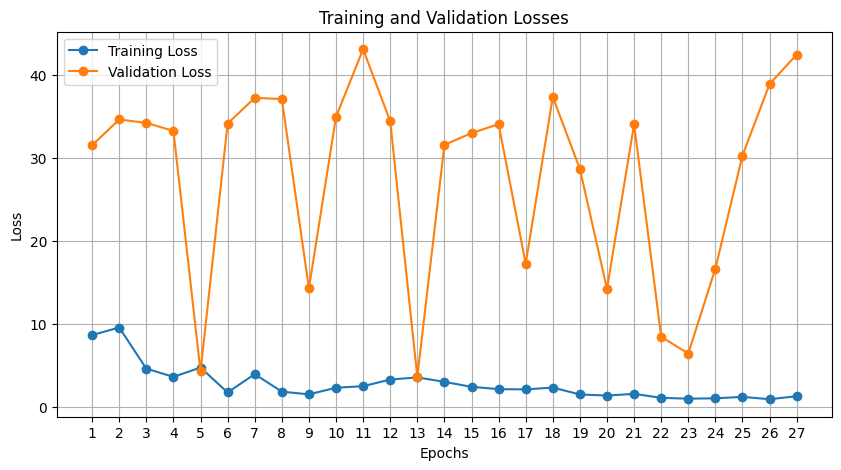

In [24]:
# Extracting training and validation losses
training_losses = torch.tensor(hist[0]).numpy().flatten()
validation_losses = torch.tensor(hist[1]).numpy().flatten()

# Get the minimum length to avoid the ValueError
min_length = min(len(training_losses), len(validation_losses))

# Trim both lists to the minimum length
training_losses_trimmed = training_losses[:min_length]
validation_losses_trimmed = validation_losses[:min_length]

# Number of epochs (should match the trimmed lists)
epochs = range(1, min_length + 1)

# Create a line plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses_trimmed, marker='o', linestyle='-', label='Training Loss')
plt.plot(epochs, validation_losses_trimmed, marker='o', linestyle='-', label='Validation Loss')

# Adding titles and labels
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.xticks(epochs)  # Set x-ticks to match the epochs
plt.show()

In [25]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)

In [26]:
torch.save(transformer.state_dict(), f'experiments/ViT{file_num + 1}.pth')

In [27]:
transformer.to(device)
transformer.load_state_dict(torch.load(f"experiments/ViT{file_num+1}.pth"))
transformer.eval()

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (linear_project): Conv2d(1, 256, kernel_size=(2, 2), stride=(2, 2))
  )
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_o): Linear(in_features=256, out_features=256, bias=True)
        (heads): ModuleList(
          (0-1): 2 x AttentionHead(
            (query): Linear(in_features=256, out_features=128, bias=True)
            (key): Linear(in_features=256, out_features=128, bias=True)
            (value): Linear(in_features=256, out_features=128, bias=True)
          )
        )
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
 

In [28]:
def predict(model, image, mask):
    model.eval()
    
    with torch.no_grad():
        image = image.to(device)
        output = model(images = image, mask = mask)
        output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
        prediction = torch.argmax(output, dim=1)
        
    return prediction.cpu().numpy()

In [29]:
for i, data in enumerate(val_loader):
    print(data)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


(tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        ...,



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


(tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        ...,



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

In [30]:
val_loss = 0.0
length = len(val_loader)
case = 0 
predictions = []
with torch.no_grad():
    for i, val_batch in tqdm(enumerate(val_loader, 0)):
        num_slices = len(val_batch[1])#Number of slces
        one_case = []#This is where we store every slice of the case 
        case_number = re.search(r'sub-(\d+)', val_batch[2][0]).group(1) # Extract the case number
        one_case.append(case_number)
        slice_list = []

        # slices_images = [] #This is where we store the images of the slices
        # slices_predictions = [] #This is where we store the predictions of the slices
        # slices_true_labels = [] #This is where we store the true labels of the slices

        print(f'Case: {case_number}')
        if num_slices != len(val_batch[0]):
            print('Not equal Number of slices:', num_slices, val_batch[0])#Checks if the number of slices of the MRI and the mask are the same
            break
        for j in range(num_slices):
            prediction_data = []#This is where we store the data of the slice predictions that will be appended to the slices_predictions list
            slice_data = []
            bounding_boxes = dataset.extract_bounding_boxes(val_batch[1][j][0].numpy())#Extracts all the bounding boxes of the slice
            cropped_images = []
            cropped_labels = []
            coordinates = []
            if len(bounding_boxes) > 0: # If there are no bounding boxes then it will skip the slice
                print('No bounding boxes found on slice ', j)
                
                for bbox in bounding_boxes: #For each bounding box it will crop the image and the label based on the given 
                    print(f"Slice {j} | ", bbox)
                    print(val_batch[0][j][0].shape)
                    cropped_images.append(
                        dataset.get_cropped_locations(
                            img = val_batch[0], 
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3]
                        ))
                    cropped_labels.append(
                        dataset.get_cropped_locations(
                            img = val_batch[1], 
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3]
                        ))
                    coordinates.append(bbox)
                if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]):## Checks if the number of cropped images and labels are the same
                    print('Not equal cropped images and labels')
                    break
                # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                # print('Cropped Images length:', len(cropped_images))
                # print('Cropped Labels length:', len(cropped_labels))
                # print('Cropped Images number of slices:', len(cropped_images[0][0][0]))
                # print('Cropped Labels number of slices:', len(cropped_labels[0][0]))
                for k, cmb in enumerate(cropped_labels[0]):# Access the CMB labels array the n checks if there are CMBs on the slice of the case
                    for l, cmb_slice in enumerate(cmb):
                        if torch.unique(cmb_slice).numel() > 1:
                            one_cmb = []
                            # print('Predicting CMB with coordinates: ', coordinates[k])
                            # print(cmb_slice.shape)
                            # print(cropped_images[0][0][0][l].shape)
                            
                            # Enable ths method to visually see what is feeded on the model
                            # print_image(cropped_images[0][0][0][l], f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            # print_image(cmb_slice, f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            print(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                            labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                            # print("Feeded inputs shape: ",inputs.shape)
                            # print("Feeded mask shape: ",labels.shape)
                            predicted_mask = predict(transformer, image = inputs.float(), mask = labels.float())
                            # print("Output shape: ",predicted_mask.shape)

                            one_cmb.append(predicted_mask[0])
                            one_cmb.append(cmb_slice)
                            one_cmb.append(coordinates[k])
                            prediction_data.append(one_cmb)
                            # print_image(predicted_mask[0], f'Predicted Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            # print_image(cmb_slice, f'Ground Truth Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')

            slice_data.append(j)
            slice_data.append(val_batch[0][j][0])
            slice_data.append(prediction_data)
            slice_data.append(val_batch[1][j][0])
            slice_list.append(slice_data)
            
            print("image shape append: ", val_batch[0][j].shape)
        # print("Images", slices_images)
        # print("Appended images: ", len(slices_images))

        one_case.append(slice_list)
        predictions.append(one_case)



0it [00:00, ?it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
1it [00:00,  3.30it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Case: 109
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 5

2it [00:01,  1.69it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


image shape append:  torch.Size([1, 1, 512, 512])
No bounding boxes found on slice  31
Slice 31 |  [166, 231, 170, 235]
torch.Size([1, 512, 512])
Slice 31 |  [139, 227, 142, 231]
torch.Size([1, 512, 512])
Slice 31 |  [136, 222, 139, 225]
torch.Size([1, 512, 512])
Slice 31 |  [171, 221, 176, 227]
torch.Size([1, 512, 512])
Slice 31 |  [132, 218, 135, 221]
torch.Size([1, 512, 512])
Predicting on Case 110 Slice 28 CMB coordinates [166, 231, 170, 235]
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9148, device='cuda:0')
Predicting on Case 110 Slice 31 CMB coordinates [166, 231, 170, 235]
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9414, device='cuda:0')
image shape append:  torch.Size([1, 1, 512, 512])
No bounding boxes found on slice  

3it [00:01,  2.11it/s]

Case: 107
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
No bounding boxes found on slice  13
Slice 13 |  [154, 205, 157, 209]
torch.Size([1, 512, 512])
Predicting on Case 107 Slice 13 CMB coordinates [154, 205, 157, 209]
Input shape before classification: torch.Size([1, 65, 256])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.

In [31]:
import torch
import matplotlib.pyplot as plt

def overlay_mask(image, mask, coordinates):
    x1, y1, x2, y2 = coordinates
    resized_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(y2-y1, x2-x1), mode='nearest').squeeze()

    mask_overlay = torch.zeros_like(image)
    mask_overlay[y1:y2, x1:x2] = resized_mask

    return image, mask_overlay

def show_image(image, mask_overlay, title):
    plt.imshow(image, cmap='gray') 
    plt.imshow(mask_overlay, cmap='hot', alpha=0.5)  
    plt.title(title)
    plt.axis('off')
    plt.show()


### Switch p for predicted and t for true mask

In [32]:
mask_type = 'p'
# mask_type = 't'

------------Case 109---------------
Length of the whole case:  2
Case number 109
Number of slices:  35
================Case 109 Slice 0================
Slice 0
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 109 Slice 1================
Slice 1
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 109 Slice 2================
Slice 2
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 109 Slice 3================
Slice 3
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 109 Slice 4================
Slice 4
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 109 Slice 5================
Slice 5
Image shape:  torch.Size([1, 512, 5

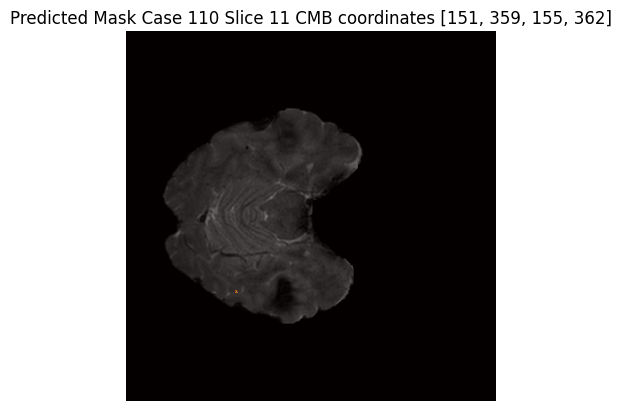

================Case 110 Slice 12================
Slice 12
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 13================
Slice 13
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 14================
Slice 14
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [95, 235, 100, 239]


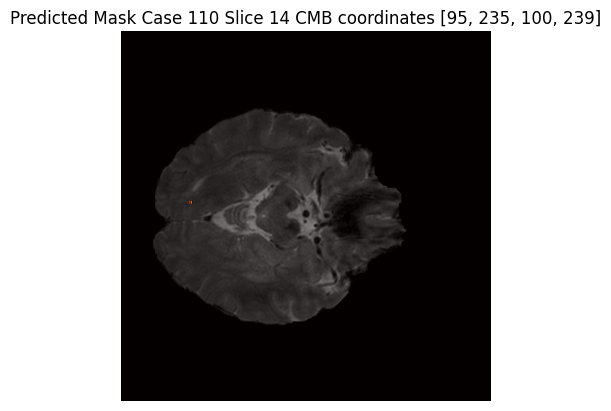

================Case 110 Slice 15================
Slice 15
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 16================
Slice 16
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 17================
Slice 17
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 18================
Slice 18
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [241, 309, 245, 313]


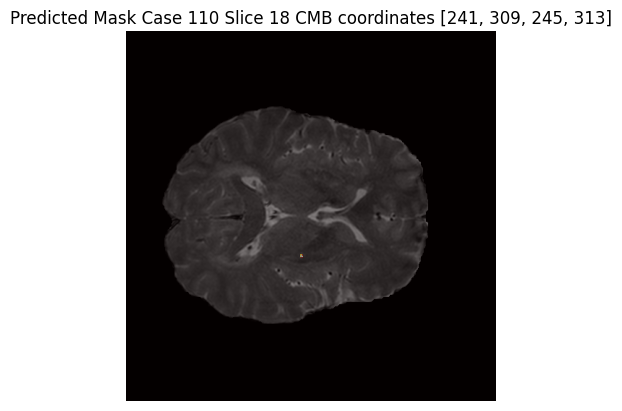

================Case 110 Slice 19================
Slice 19
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [85, 230, 91, 236]


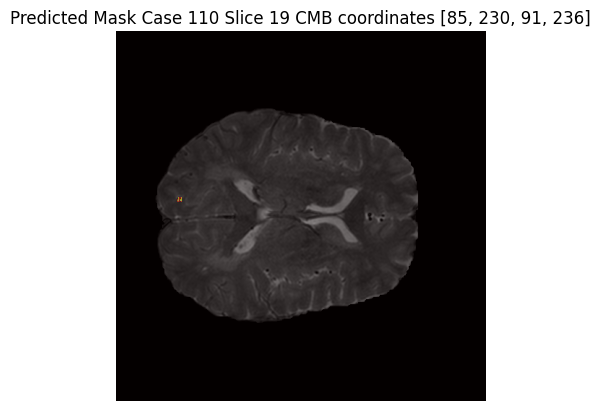

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [85, 230, 91, 236]


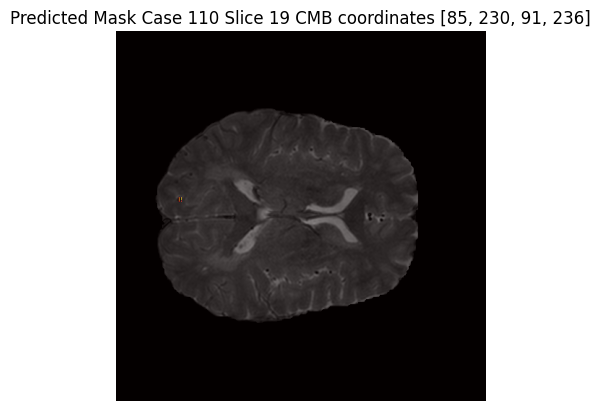

================Case 110 Slice 20================
Slice 20
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [93, 311, 97, 315]


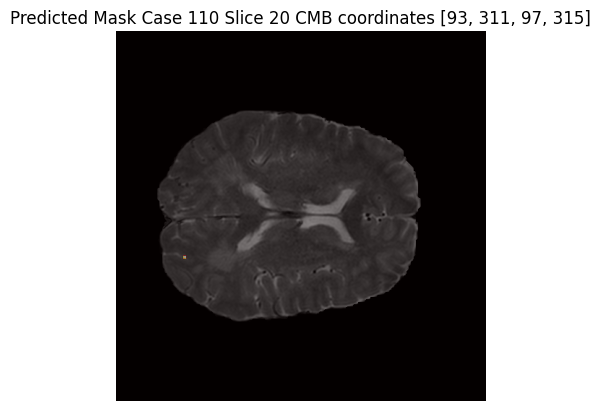

================Case 110 Slice 21================
Slice 21
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [82, 312, 86, 316]


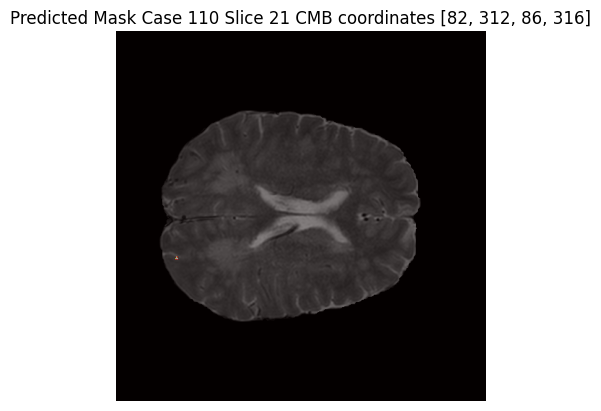

================Case 110 Slice 22================
Slice 22
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [177, 223, 181, 228]


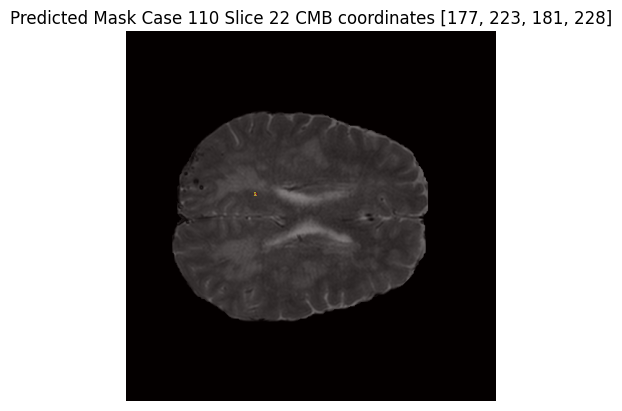

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [177, 223, 181, 228]


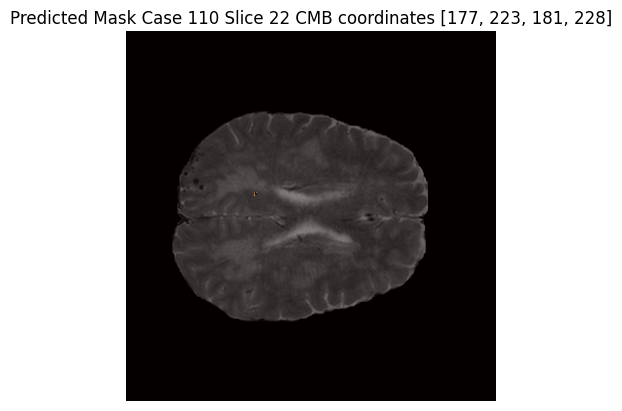

================Case 110 Slice 23================
Slice 23
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [182, 234, 186, 239]


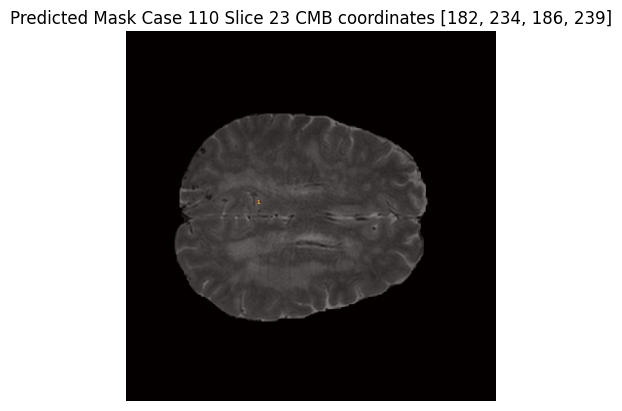

================Case 110 Slice 24================
Slice 24
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [114, 247, 118, 251]


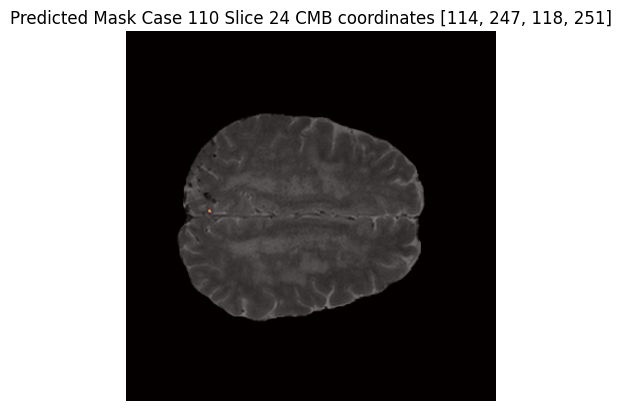

================Case 110 Slice 25================
Slice 25
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [99, 321, 103, 325]


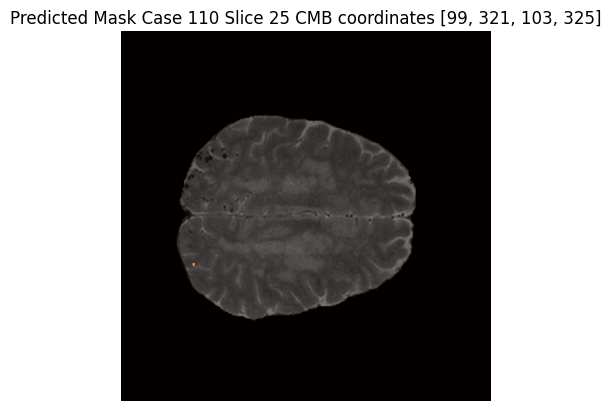

================Case 110 Slice 26================
Slice 26
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [118, 237, 122, 240]


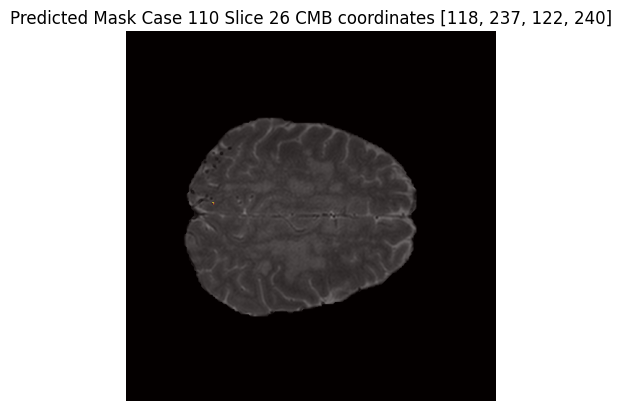

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [118, 237, 122, 240]


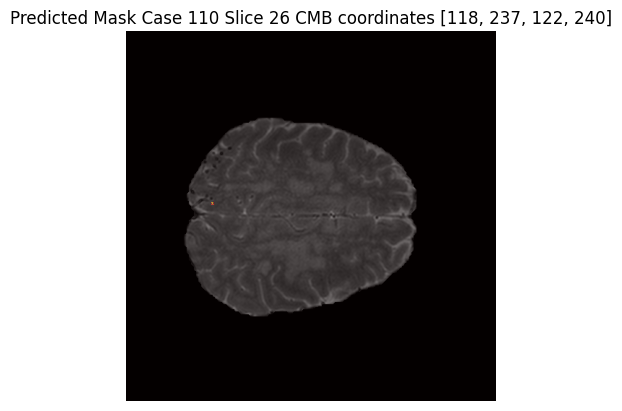

================Case 110 Slice 27================
Slice 27
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [117, 297, 121, 302]


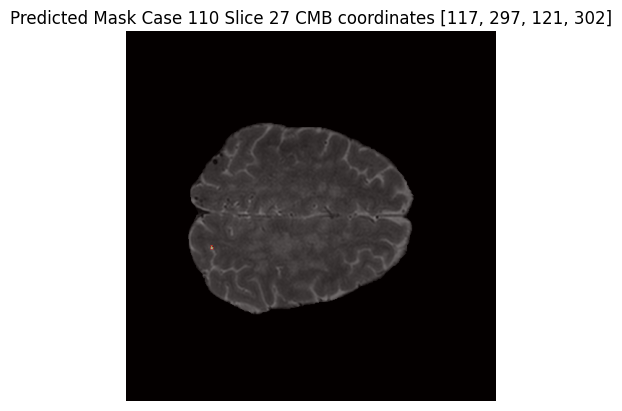

================Case 110 Slice 28================
Slice 28
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [169, 245, 173, 249]


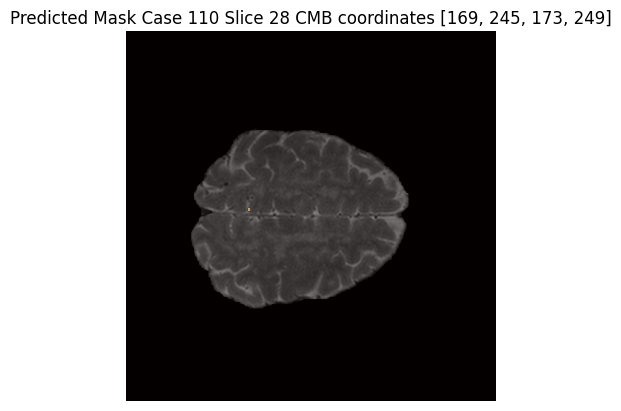

================Case 110 Slice 29================
Slice 29
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [141, 232, 145, 236]


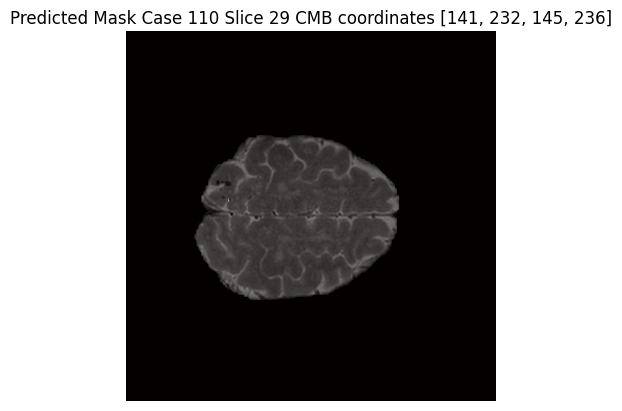

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [141, 232, 145, 236]


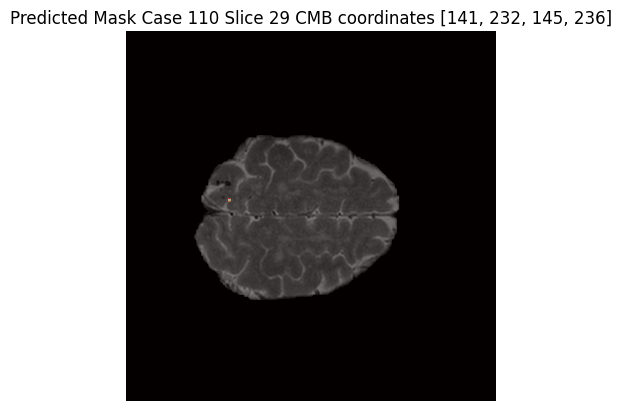

================Case 110 Slice 30================
Slice 30
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [150, 297, 154, 302]


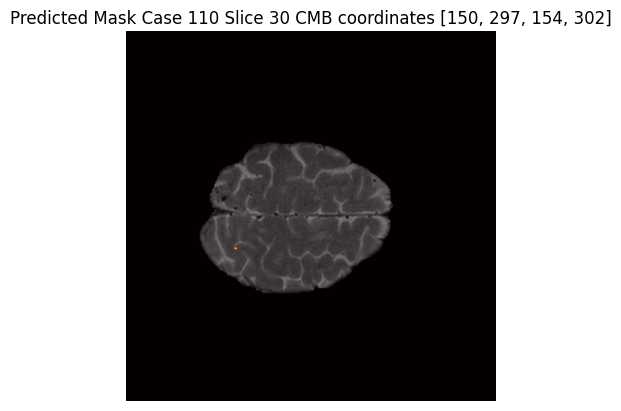

================Case 110 Slice 31================
Slice 31
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [166, 231, 170, 235]


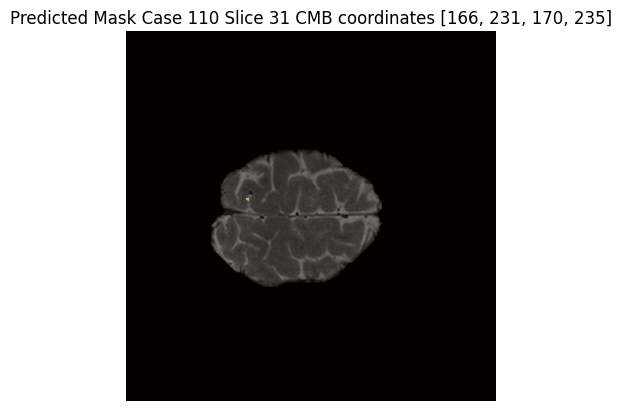

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [166, 231, 170, 235]


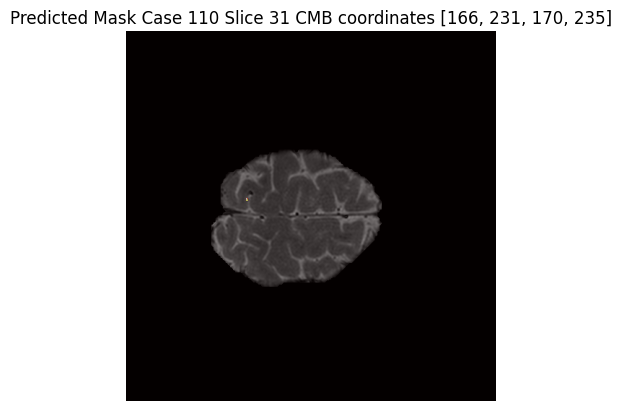

================Case 110 Slice 32================
Slice 32
Image shape:  torch.Size([1, 512, 512])
Prediction length:  4
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [172, 221, 179, 227]


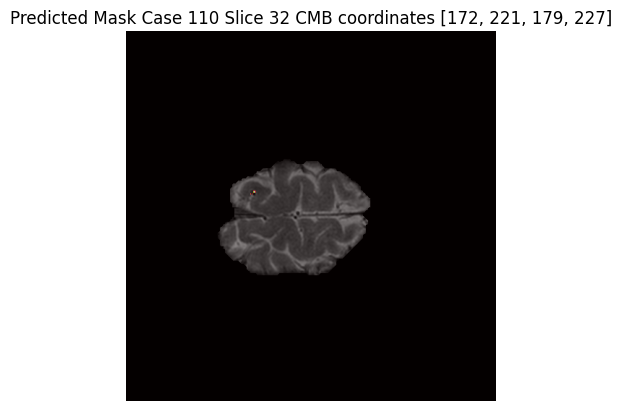

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [172, 221, 179, 227]


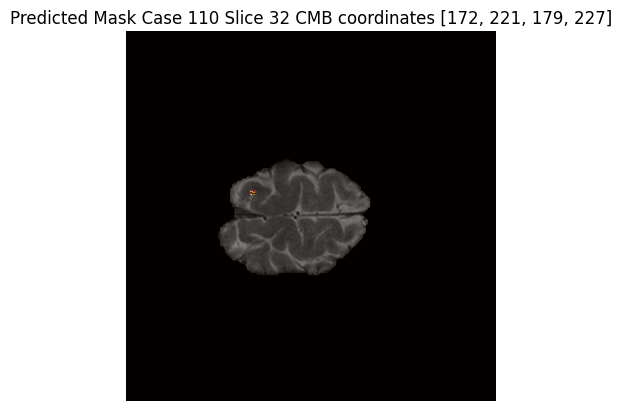

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [172, 221, 179, 227]


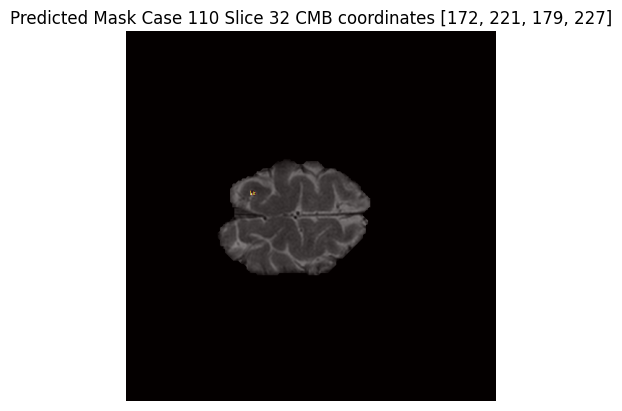

Prediction 3
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [172, 221, 179, 227]


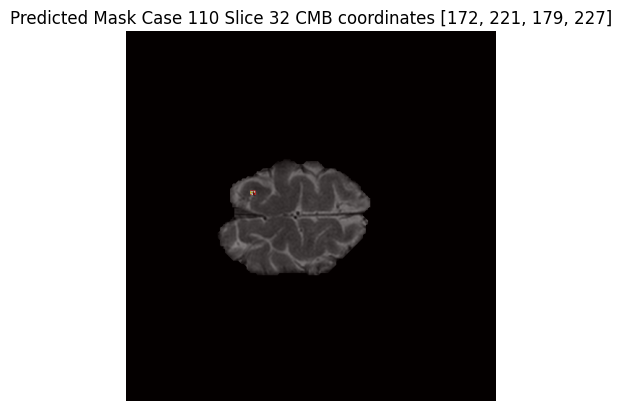

================Case 110 Slice 33================
Slice 33
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 34================
Slice 34
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
------------Case 107---------------
Length of the whole case:  2
Case number 107
Number of slices:  35
================Case 107 Slice 0================
Slice 0
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 1================
Slice 1
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 2================
Slice 2
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 3================
Slice 3
Image shape:  torch.Size([1, 51

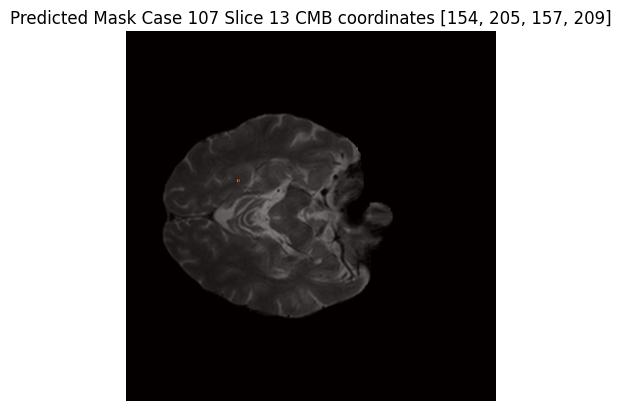

================Case 107 Slice 14================
Slice 14
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 15================
Slice 15
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 16================
Slice 16
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 17================
Slice 17
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 18================
Slice 18
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 19================
Slice 19
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 1

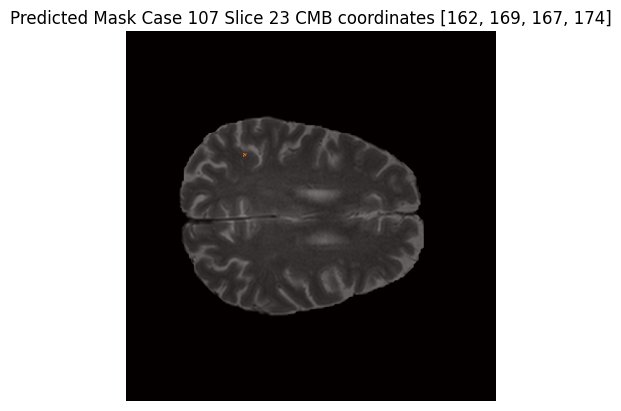

================Case 107 Slice 24================
Slice 24
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 25================
Slice 25
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 26================
Slice 26
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 27================
Slice 27
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 28================
Slice 28
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 29================
Slice 29
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 1

In [33]:
for case in predictions:
    case_number = case[0]
    print(f"------------Case {case_number}---------------")
    print("Length of the whole case: ", len(case))
    print("Case number", case[0])
    print("Number of slices: ", len(case[1]))

    for i, case_slice in enumerate(case[1]):
        slice_number = case_slice[0]
        print(f"================Case {case_number} Slice {slice_number}================")
        print(f"Slice {slice_number}")
        print("Image shape: ", case_slice[1].shape)
        print("Prediction length: ", len(case_slice[2]))
        print("True label shape: ", case_slice[3].shape)
        slice_image = case_slice[1][0]
        slice_prediction = case_slice[2]
        # Assuming your slice_prediction contains multiple masks
        for j, slice_pred in enumerate(slice_prediction):
            print(f"Prediction {j}")
            print("Predicted Mask shape: ", slice_pred[0].shape)
            print("True Mask shape: ", slice_pred[1].shape)
            print("Coordinates: ", slice_pred[2])
            
            predicted_mask = slice_pred[0]  
            true_mask = slice_pred[1]       
            coordinates = slice_pred[2]     
            

            predicted_mask = torch.tensor(predicted_mask, dtype=torch.float32)
            
   
            image_slice = slice_image
            
            
            if mask_type == 'p':
                image, mask_overlay = overlay_mask(image_slice, predicted_mask, coordinates)
                show_image(image, mask_overlay, f'Predicted Mask Case {case_number} Slice {slice_number} CMB coordinates {coordinates}')
            elif mask_type == 't':
                image, mask_overlay = overlay_mask(image_slice, true_mask, coordinates)
                show_image(image, mask_overlay, f'True Mask Case {case_number} Slice {slice_number} CMB coordinates {coordinates}')
            else:
                print("Invalid input! Skipping this slice.")
    # break

In [ ]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
